In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_blobs, make_circles
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, learning_curve
from scipy.stats import multivariate_normal
from time import time
import warnings
import random
warnings.filterwarnings("ignore")

%matplotlib notebook
plt.style.use('ggplot')

# TP n°2 : Support Vector Machine (SVM)

## Preliminary questions

**1)** Show that the primal problem solved by the SVM can be rewritten as follows :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

### Answer

The SVM solves the problem :

$$
\left\{
    \begin{array}{ll}
        (w^{*}, w_{0}^{*}, \xi^{*} \in \mathbb{R}^{n}) \in argmin_{w \in \mathcal{H}, w_{0} \in \mathbb{R}, \xi \in \mathbb{R}^{n}} (\frac{1}{2} ||w||^{2} + C \sum_{i=1}^{n} \xi_{i})  \\
        \xi_{i} \geq 0 \quad \forall i \in \{ 1,..., n\} \\
        y_{i}(<w,\phi(x_{i})> + w_{0}) \geq 1-\xi_{i} \quad \forall i \in \{ 1,..., n\}  \\
    \end{array}
\right.
$$

i.e :

$$
\left\{
    \begin{array}{ll}
        (w^{*}, w_{0}^{*}, \xi^{*} \in \mathbb{R}^{n}) \in argmin_{w \in \mathcal{H}, w_{0} \in \mathbb{R}, \xi \in \mathbb{R}^{n}} (\frac{1}{2} ||w||^{2} + C \sum_{i=1}^{n} \xi_{i})  \\
        \xi_{i} \geq 0 \,and \, y_{i}(<w,\phi(x_{i})> + w_{0}) \geq 1-\xi_{i} \quad \forall i \in \{ 1,..., n\} \\
    \end{array}
\right.
$$

so :

$$
\left\{
    \begin{array}{ll}
        (w^{*}, w_{0}^{*}, \xi^{*} \in \mathbb{R}^{n}) \in argmin_{w \in \mathcal{H}, w_{0} \in \mathbb{R}, \xi \in \mathbb{R}^{n}} (\frac{1}{2} ||w||^{2} + C \sum_{i=1}^{n} \xi_{i})  \\
        \xi_{i} \geq [\, y_{i}(<w,\phi(x_{i})> + w_{0}) \geq 1-\xi_{i}]_{+} \geq 0 \quad \forall i \in \{ 1,..., n\} \\
    \end{array}
\right.
$$

It is obvious that the term $\sum_{i=1}^{n} \xi_{i}$ is minimum for $\xi_{i} = [\, y_{i}(<w,\phi(x_{i})> + w_{0}) \geq 1-\xi_{i}]_{+} \geq 0 \quad \forall i \in \{ 1,..., n\}$. Hence, by replacing in the expression, the SVM solves :

$$ \text{argmin}_{\mathbf{w} \in \mathcal{H}, w_0 \in \mathbb{R} } \left( \frac{1}{2}||\mathbf{w}||^2 + C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+ \right) $$

**2)** Explain the sentence : "an SVM minimizes the classification error using a convex upper bound". The function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ is called *Hinge* (*charnière* en français). Explain the difference between the pivotal loss and the loss of binary classification.

### Answer

The classification error is linked to the $\xi_{i}$ (which represents the errors) and thus is represented by the term $C \sum_{i=1}^n [ 1 - y_i ( \langle \mathbf{w}, \Phi(\mathbf{x_i}) \rangle + w_0 )]_+$. Moreover, this term is convex (the function $x \rightarrow [1 - x]_+ = \text{max}(0, 1-x)$ being convex) so the SVM minimizes the classification error with a convex upper bound indeed.

Besides, binary classification (often for labels in (0, 1)) allows less error as it is only concerned to know if the label is 0 or 1, whereas the pivotal loss concentrates on having the right sign (labels are in (-1, 1)), allocating more error when there is dissimilarity in the sign of the true label and predicted label, hence it increases the margin between the hyperplanes, what the loss of binary classification does not do.

## Example of using SVC (originally in ```svm_script.py```)

In [2]:
from matplotlib import rc
from matplotlib.colors import ListedColormap
import seaborn as sns

plt.close('all')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
# text.usetex is set as False by default to avoid problems with student computers
params = {'axes.labelsize': 12,
          'font.size': 16,
          'legend.fontsize': 16,
          'text.usetex': False,
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)

sns.set_context("poster")
sns.set_palette("colorblind")
sns.set_style("white")
sns.axes_style()

###############################################################################
#               Data Generation
###############################################################################


def rand_gauss(n=100, mu=[1, 1], sigmas=[0.1, 0.1]):
    """ Sample n points from a Gaussian variable with center mu,
    and std deviation sigma
    """
    d = len(mu)
    res = np.random.randn(n, d)
    return np.array(res * sigmas + mu)


def rand_bi_gauss(n1=100, n2=100, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.1, 0.1],
                  sigmas2=[0.1, 0.1]):
    """ Sample n1 and n2 points from two Gaussian variables centered in mu1,
    mu2, with respective std deviations sigma1 and sigma2
    """
    ex1 = rand_gauss(n1, mu1, sigmas1)
    ex2 = rand_gauss(n2, mu2, sigmas2)
    y = np.hstack([np.ones(n1), -1 * np.ones(n2)])
    X = np.vstack([ex1, ex2])
    ind = np.random.permutation(n1 + n2)
    return X[ind, :], y[ind]

###############################################################################
#           Displaying labeled data
###############################################################################

symlist = ['o', 's', 'D', 'x', '+', '*', 'p', 'v', '-', '^']


def plot_2d(data, y=None, w=None, alpha_choice=1):
    """ Plot in 2D the dataset data, colors and symbols according to the
    class given by the vector y (if given); the separating hyperplan w can
    also be displayed if asked"""

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    if y is None:
        labs = [""]
        idxbyclass = [range(data.shape[0])]
    else:
        labs = np.unique(y)
        idxbyclass = [np.where(y == labs[i])[0] for i in range(len(labs))]

    for i in range(len(labs)):
        plt.scatter(data[idxbyclass[i], 0], data[idxbyclass[i], 1],
                    c=[color_blind_list[i]], s=80, marker=symlist[i])
    plt.ylim([np.min(data[:, 1]), np.max(data[:, 1])])
    plt.xlim([np.min(data[:, 0]), np.max(data[:, 0])])
    mx = np.min(data[:, 0])
    maxx = np.max(data[:, 0])
    if w is not None:
        plt.plot([mx, maxx], [mx * -w[1] / w[2] - w[0] / w[2],
                              maxx * -w[1] / w[2] - w[0] / w[2]],
                 "g", alpha=alpha_choice)

###############################################################################
#           Displaying tools for the Frontiere
###############################################################################


def frontiere(f, X, y, w=None, step=50, alpha_choice=1, colorbar=True,
              samples=True):
    """ trace la frontiere pour la fonction de decision f"""
    # construct cmap

    min_tot0 = np.min(X[:, 0])
    min_tot1 = np.min(X[:, 1])

    max_tot0 = np.max(X[:, 0])
    max_tot1 = np.max(X[:, 1])
    delta0 = (max_tot0 - min_tot0)
    delta1 = (max_tot1 - min_tot1)
    xx, yy = np.meshgrid(np.arange(min_tot0, max_tot0, delta0 / step),
                         np.arange(min_tot1, max_tot1, delta1 / step))
    z = np.array([f(vec.reshape(1, -1)) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', interpolation="mitchell", alpha=0.80,
               cmap=my_cmap, extent=[min_tot0, max_tot0, min_tot1, max_tot1])
    if colorbar is True:
        ax = plt.gca()
        cbar = plt.colorbar(ticks=labels)
        cbar.ax.set_yticklabels(labels)

    labels = np.unique(y)
    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    sns.set_palette(color_blind_list)
    ax = plt.gca()
    if samples is True:
        for i, label in enumerate(y):
            label_num = np.where(labels == label)[0][0]
            plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[label_num]],
                        s=80, marker=symlist[label_num])
    plt.xlim([min_tot0, max_tot0])
    plt.ylim([min_tot1, max_tot1])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])
    if w is not None:
        plt.plot([min_tot0, max_tot0],
                 [min_tot0 * -w[1] / w[2] - w[0] / w[2],
                  max_tot0 * -w[1] / w[2] - w[0] / w[2]],
                 "k", alpha=alpha_choice)

<IPython.core.display.Javascript object>


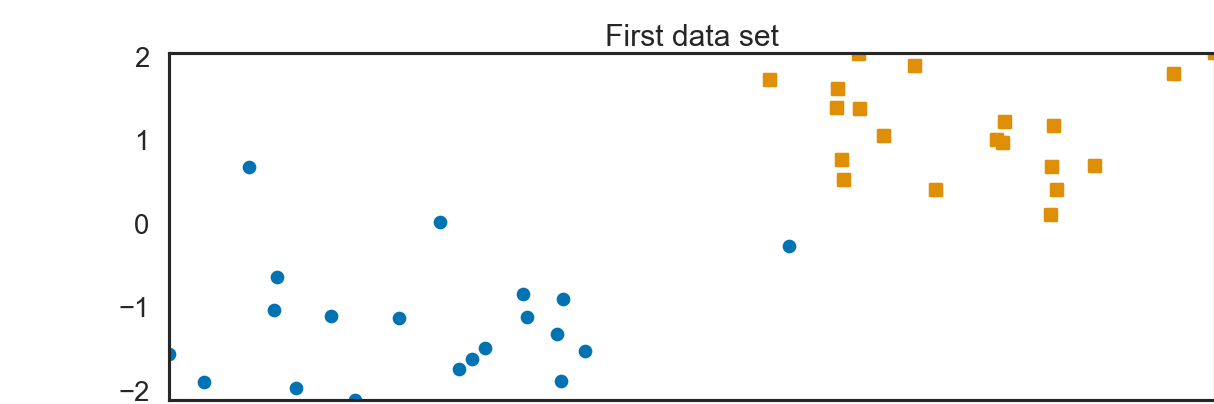

Score : 0.95


<IPython.core.display.Javascript object>


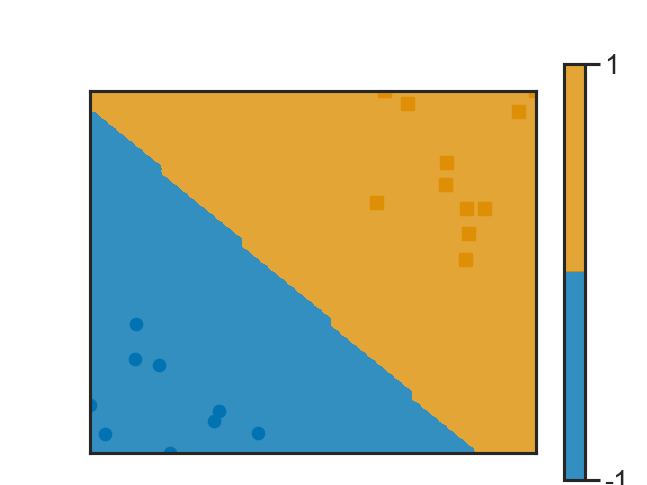

[ 1 -1  1  1  1 -1  1  1  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1]


In [20]:
# This is an example of using SVC for data generated in the same way as the previous TP
n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
X1, y1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

plt.show()
plt.close("all")
plt.ion()
plt.figure(1, figsize=(15, 5))
plt.title('First data set')
plot_2d(X1, y1)

X_train = X1[::2]
Y_train = y1[::2].astype(int)
X_test = X1[1::2]
Y_test = y1[1::2].astype(int)

# fit the model with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train, Y_train)

# predict labels for the test data base
y_pred = clf.predict(X_test)

# check your score
score = clf.score(X_test, Y_test)
print('Score : %s' % score)
# display the frontiere


def f(xx):
    """Classifier: needed to avoid warning due to shape issues"""
    return clf.predict(xx.reshape(1, -1))

plt.figure(2)
frontiere(f, X_train, Y_train, w=None, step=50, alpha_choice=1)

## Linear SVM

**3)** Draw a i.i.d. sample from a mixture of two Gaussian distrtibutions : each class is a Gaussian with specific parameters. This time, use the function make_blobs available in sklearn.datasets library. Reserve 75% of the data for training and 25% for the test data.

<IPython.core.display.Javascript object>


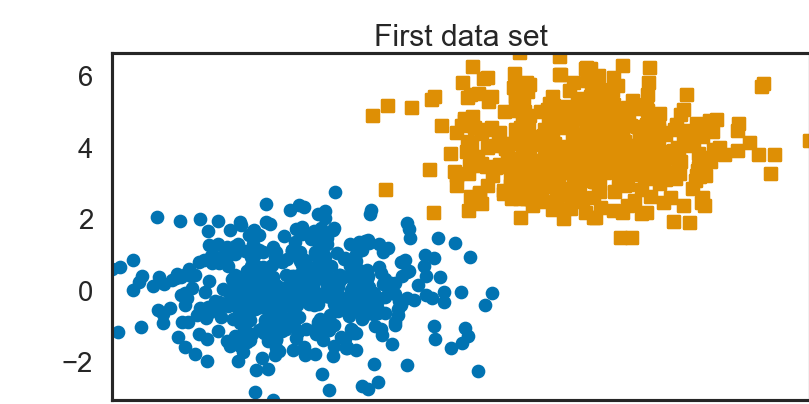

In [3]:
X, y = make_blobs(n_samples=1000, centers=[[0,0],[4,4]], n_features=2,cluster_std=[1,1],random_state=0)
plt.close("all")
plt.ion()
plt.figure(1, figsize=(10, 5))
plt.title('First data set')
plot_2d(X, y)


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=69)

(750, 2)


**4)** Since the probability distributions are known, numerically estimate the Bayes risk.

In [7]:
from scipy.stats import multivariate_normal
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

n=1000
risk = 0
# we have a formula for the Bayes risk for a binary classification and we will compute it
for i in range(n+1):
    temp = np.random.random()
    if temp >=1/2:
        # then y = 1
        x = np.random.multivariate_normal([4,4], np.eye(2), 1)
    else:
        # y = 0
        x = np.random.multivariate_normal([0,0], np.eye(2), 1)
    f0 = multivariate_normal.pdf(x, mean=[0,0], cov=np.eye(2))
    f1 = multivariate_normal.pdf(x, mean=[4,4], cov=np.eye(2))
    eta = f1/(f1 + f0)
    risk += min(eta, 1-eta)

risk /= n
risk

0.002864199430963044

**5)** Draw the decision boundary H induced by SVM as well as the hyperplanes H1 and H−1. Vary the parameter C to see its impact on the number of support vectors. We can use the example https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html.

<IPython.core.display.Javascript object>


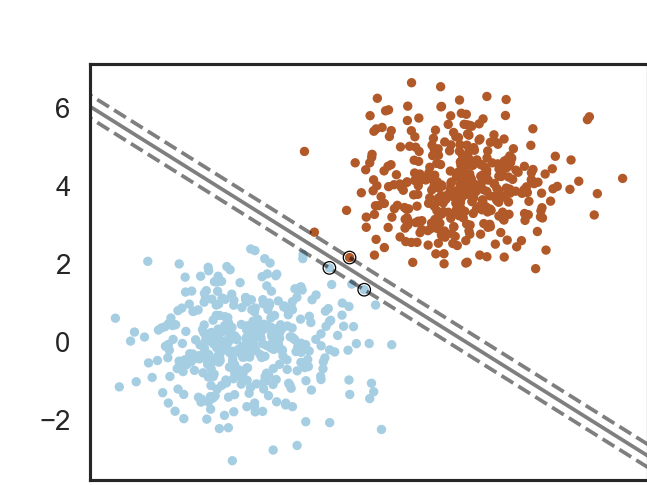

In [8]:
clf = svm.SVC(kernel='linear', C=100)
clf.fit(X_train, Y_train)

plt.close("all")
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=30, cmap=plt.cm.Paired)


# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

The number of support vectors increases as C decreases and tends to 0.

**6)** Define the Gaussian classes such that the two distributions overlap. Draw an i.i.d. sample from the joint probability distribution. Apply a 5-fold Cross-Validation to find the optimal parameter C∗ to classify this new dataset using a linear kernel.

<IPython.core.display.Javascript object>


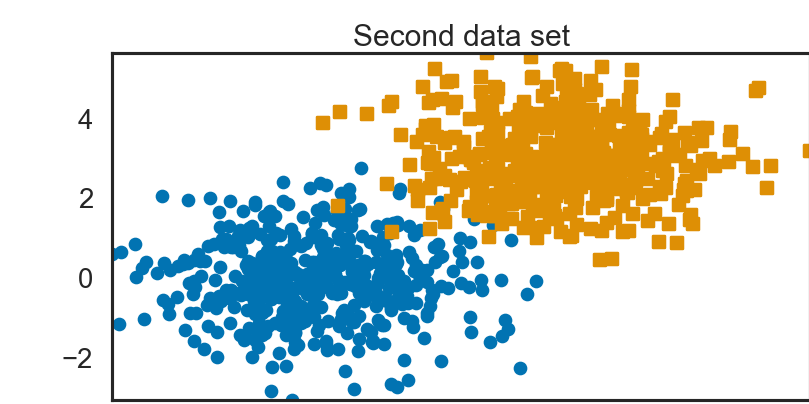

In [9]:
# Generate data and verify graphically that the two classes overlap
X, y = make_blobs(n_samples=1000, centers=[[0,0],[3,3]], n_features=2,cluster_std=[1,1],random_state=0)
plt.close("all")
plt.ion()
plt.figure(1, figsize=(10, 5))
plt.title('Second data set')
plot_2d(X, y)

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=69)

In [10]:
# Find the best working C with a 5-fold cross-validation
parameters = {'C':np.logspace(-1, 3, num=30)}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, Y_train)
clf.best_params_

{'C': 0.1}

**7)** Show how tuning SVM hyperparameters on training data, for example by taking a Gaussian kernel (the parameters are therefore gamma and C), can lead to overfitting.

<IPython.core.display.Javascript object>


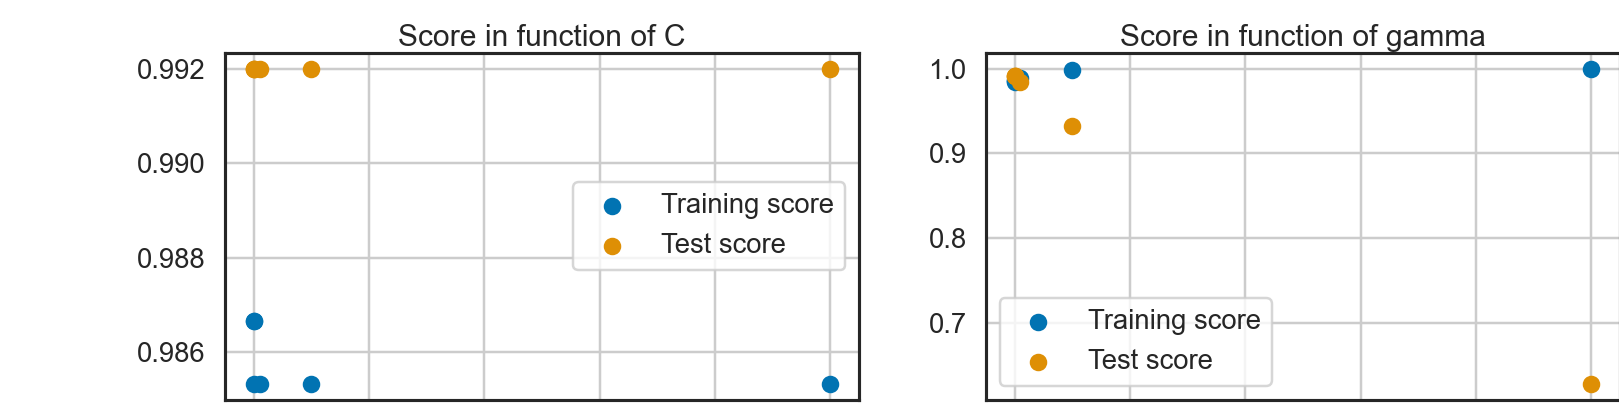

Influence of C : 

Training score for C= 0.01 : 0.9866666666666667
Testing score for C= 0.01 : 0.992
Training score for C= 0.1 : 0.9853333333333333
Testing score for C= 0.1 : 0.992
Training score for C= 1 : 0.9866666666666667
Testing score for C= 1 : 0.992
Training score for C= 10 : 0.9853333333333333
Testing score for C= 10 : 0.992
Training score for C= 100 : 0.9853333333333333
Testing score for C= 100 : 0.992
Training score for C= 1000 : 0.9853333333333333
Testing score for C= 1000 : 0.992

 Influence of gamma : 

Training score for gamma= 0.01 : 0.9866666666666667
Testing score for gamma= 0.01 : 0.992
Training score for gamma= 0.1 : 0.9853333333333333
Testing score for gamma= 0.1 : 0.992
Training score for gamma= 1 : 0.984
Testing score for gamma= 1 : 0.992
Training score for gamma= 10 : 0.9893333333333333
Testing score for gamma= 10 : 0.984
Training score for gamma= 100 : 0.9986666666666667
Testing score for gamma= 100 : 0.932
Training score for gamma= 1000 : 1.0
Testing score for 

<function matplotlib.pyplot.show(block=None)>

In [11]:
# Vary the parameter of the kernel and check the difference between training and testing scores

_, axes = plt.subplots(1, 2, figsize=(20, 5))
train_score = []
test_score = []
print("Influence of C : \n")
for C in [0.01, 0.1, 1, 10, 100, 1000]:
    clf = svm.SVC(kernel='rbf', C=C)
    clf.fit(X_train, Y_train)
    # check your score
    score = clf.score(X_train, Y_train)
    print('Training score for C= %s : %s'  % (C,score))
    train_score.append(score)
    score = clf.score(X_test, Y_test)
    test_score.append(score)
    print('Testing score for C= %s : %s'  % (C,score))

axes[0].set_title("Score in function of C")
axes[0].grid()
axes[0].scatter([0.01, 0.1, 1, 10, 100, 1000],train_score, label="Training score")
axes[0].scatter([0.01, 0.1, 1, 10, 100, 1000],test_score, label="Test score")
axes[0].legend(loc="best")

train_score = []
test_score = []
print("\n Influence of gamma : \n")
for gamma in [0.01, 0.1, 1, 10, 100, 1000]:
    clf = svm.SVC(kernel='rbf', gamma=gamma)
    clf.fit(X_train, Y_train)
    # check your score
    score = clf.score(X_train, Y_train)
    print('Training score for gamma= %s : %s'  % (gamma,score))
    train_score.append(score)
    score = clf.score(X_test, Y_test)
    test_score.append(score)
    print('Testing score for gamma= %s : %s'  % (gamma,score))
    
axes[1].set_title("Score in function of gamma")
axes[1].grid()
axes[1].scatter([0.01, 0.1, 1, 10, 100, 1000],train_score, label="Training score")
axes[1].scatter([0.01, 0.1, 1, 10, 100, 1000],test_score, label="Test score")
axes[1].legend(loc="best")

plt.show

## Non linear SVM

**8)** Define a new binary nonlinear classification problem : for instance, define one class as a Gaussian surrounded by the other chosen as a circle class, or choose the second class as a mixture of two Gaussian in such way that the separation problem is nonlinear. Generate a non-linearly separable dataset (we could for example use the function make_blobs available in sklearn.datasetslibrary ).

<IPython.core.display.Javascript object>


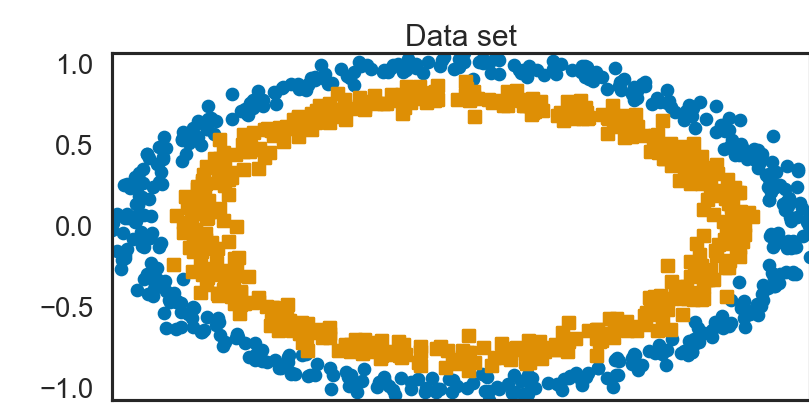

In [12]:
X, y = make_circles(n_samples=1000, noise=0.04)
plt.close("all")
plt.ion()
plt.figure(1, figsize=(10, 5))
plt.title('Data set')
plot_2d(X, y)


In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=69)


**9)** Use an SVM with a Gaussian kernel then a polynomial (with well-adapted parameters) then plot the decision boundaries of these algorithms on separate graphs.

In [ ]:
# With Gaussian kernel
t0 = time()
parameters = {'C':np.logspace(0, 3, num=30), 'gamma':[0.01,0.1,1,10,100]}
svc = svm.SVC()
clf1 = GridSearchCV(svc, parameters)
clf1.fit(X_train, Y_train)
print("Best parameters : ", clf1.best_params_)
clf = svm.SVC(kernel='rbf', C=clf1.best_params_.get("C"), gamma=clf1.best_params_.get("gamma"))
clf.fit(X_train, Y_train)
score = clf.score(X_train, Y_train)
print('Training score : %s'  % score)
score_rbf = clf.score(X_test, Y_test)
print('Test score : %s'  % score_rbf)
n_sup_vec_rbf = len(clf.support_vectors_)
#clf = svm.SVC(kernel='rbf', C=10)
#clf.fit(X_train, Y_train)
t_rbf = time()-t0


plt.close("all")
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=30, cmap=plt.cm.Paired)
plt.title("Decision boundaries with a gaussian kernel")


# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()



# With polynomial kernel
t0 = time()
parameters = {'C':np.logspace(0, 3, num=10), 'degree':[2,3,4,5], 'coef0':np.linspace(0,10,10)}
svc = svm.SVC(kernel='poly')
clf1 = GridSearchCV(svc, parameters)
clf1.fit(X_train, Y_train)
print("Best parameters : ", clf1.best_params_)
clf = svm.SVC(kernel='rbf', C=clf1.best_params_.get("C"), degree=clf1.best_params_.get("degree"), gamma='auto', coef0=clf1.best_params_.get("coef0"))
clf.fit(X_train, Y_train)
score = clf.score(X_train, Y_train)
print('Training score : %s'  % score)
score_poly = clf.score(X_test, Y_test)
print('Test score : %s'  % score_poly)
n_sup_vec_poly = len(clf.support_vectors_)
#clf = svm.SVC(kernel='poly', C=0.1, gamma='auto')
#clf.fit(X_train, Y_train)
t_poly = time() - t0

plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, s=30, cmap=plt.cm.Paired)
plt.title("Decision boundaries with a polynomial kernel")


# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

**10)** We wish to compare classification performance between different SVMs based on different kernels
(linear, polynomial and Gaussian). Propose a method allowing to compare these three algorithms.

### Answer

Firstly, we can compare their time of execution. Secondly, one can compare their score. And thirdly, one can compare the number of support vectors. Indeed, the number of support vectors inside the margin can be linked to the classification error : the more there are classification errors, the more there are points inside the margin (and so support vectors).


Best parameters :  {'C': 1.0}
Training score : 0.5066666666666667
Test score : 0.48


<IPython.core.display.Javascript object>


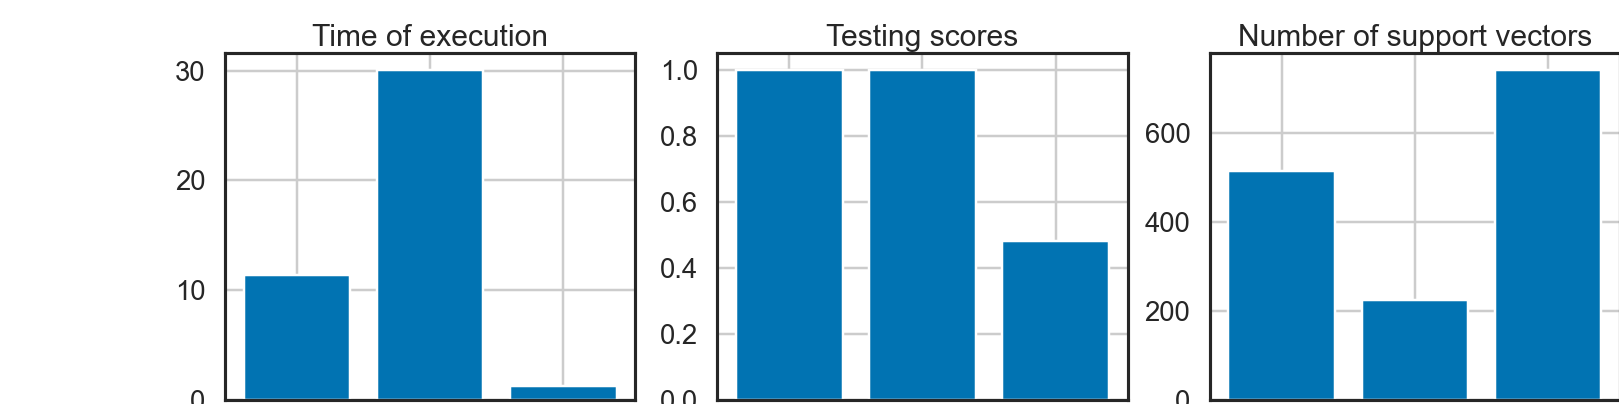

In [15]:
t0 = time()
parameters = {'C':np.logspace(0, 3, num=10)}
svc = svm.SVC(kernel='linear')
clf1 = GridSearchCV(svc, parameters)
clf1.fit(X_train, Y_train)
print("Best parameters : ", clf1.best_params_)
clf = svm.SVC(kernel='linear', C=clf1.best_params_.get("C"))
clf.fit(X_train, Y_train)
score = clf.score(X_train, Y_train)
print('Training score : %s'  % score)
score_linear = clf.score(X_test, Y_test)
print('Test score : %s'  % score_linear)
n_sup_vec_linear = len(clf.support_vectors_)
t_linear = time() - t0

_, axes = plt.subplots(1, 3, figsize=(20, 5))

# Plot execution time
axes[0].set_title("Time of execution")
axes[0].grid()
axes[0].bar(["rbf", "poly", "linear"],[t_rbf, t_poly, t_linear])

# Plot scores
axes[1].set_title("Testing scores")
axes[1].grid()
axes[1].bar(["rbf", "poly", "linear"],[score_rbf, score_poly, score_linear])

# Plot number of support vectors
axes[2].set_title("Number of support vectors")
axes[2].grid()
axes[2].bar(["rbf", "poly", "linear"],[n_sup_vec_rbf, n_sup_vec_poly, n_sup_vec_linear])

plt.show()

**11)** Draw the learning curve of the algorithm : with fixed hyper-parameters and fixed test set, calculate the training and test errors by using training sub-sets of training data of various sizes (drawn randomly). Plot the train and test error based on the size of the train set subset. Estimate and display the accuracy of the Bayes predictor on the same graph. Comment.

In [ ]:
# Based on the previous bar graph, we will choose a gaussian kernel

train_sizes, train_scores, test_scores = learning_curve(SVC(kernel='rbf'), X, y, train_sizes=random.sample(list(np.linspace(0.1,1,100)), 50), cv=5)
train_score=[]
test_score=[]
for i in range(len(train_scores)):
    train_score.append(np.mean(train_scores[i]))
    test_score.append(test_scores[i][0])
plt.scatter(train_sizes, train_score, label='training score')
plt.scatter(train_sizes, test_score, label='test score')
plt.xlabel("Training subset size")
plt.ylabel("Score")
plt.legend(loc='best')
plt.show()

In [ ]:
# Do a Monte-Carlo estimation of the Bayes Risk (given the gaussian distributions you used to generate data)

n=10000
risk = 0
# we have a formula for the Bayes risk for a binary classification and we will compute it
for i in range(n+1):
    temp = np.random.random()
    if temp >1/2:
        # then y = 1
        x = np.random.multivariate_normal([0,0], np.eye(2), 1)
    else:
        # y = 0
        x = np.random.multivariate_normal([0,0], 0.8*np.eye(2), 1)
    f0 = multivariate_normal.pdf(x, mean=[0,0], cov=np.eye(2))
    f1 = multivariate_normal.pdf(x, mean=[0,0], cov=8*np.eye(2))
    eta = 3*f1/4*(f1 + f0)
    risk += min(eta, 1-eta)

risk /= n
print("Estimation of the Bayes risk : ", risk)
print("Estimation of the Bayes accuracy : ", 1-risk)

In [ ]:
# Add this estimation to the plot of train/test error


plt.scatter(train_sizes, train_score, label='training score')
plt.scatter(train_sizes, test_score, label='test score')
plt.plot(train_sizes, [1-risk]*len(train_sizes), label='Bayes accuracy estimation', color='green')
plt.xlabel("Training subset size")
plt.ylabel("Score")
plt.legend(loc='best')
plt.show()

### Comments 

We can see that there are less and less errors as the size of the train subset increases and tends to the Bayes accuracy. It seems logic as we have more data to "learn correctly" from and this is coherent.

**12)** Add noise to the dataset by randomly modifying the labels of some training data. Then, draw the complexity curves of the algorithm : with set train and test set, draw the train and test error as a function of the complexity (i.e. as a function of the value of the hyper-parameter controlling the complexity, or the number of support vector). Comment.


In [ ]:
# Modify the class of some data points randomly

modif = random.sample([k for k in range(len(Y_train))], 400)
Y_train_noised = Y_train.copy()
for i in modif:
    if Y_train[i]==0:
        Y_train_noised[i]=1
    else:
        Y_train_noised[i]=0

In [ ]:
C_list = np.arange(1,200,0.5)
train_error=[]
test_error=[]
for c in C_list:
    clf = svm.SVC(kernel='rbf', C=c)
    clf.fit(X_train, Y_train_noised)
    train_error.append(1-clf.score(X_train, Y_train_noised))
    test_error.append(1-clf.score(X_test, Y_test))

plt.scatter(C_list, train_error, label='train error')
plt.scatter(C_list, test_error, label='test error')
plt.xlabel("C")
plt.ylabel("Error")
plt.legend()
plt.show()

### Comments

First of all, we can see  that modifying randomly the label of some data has more impact when the complexity is low and the error tends to stabilize as the complexity increases (which is quite reassuring). However, we can see that the model is quite sensitive to changes (and not well labelised data) as the test error is quite high...

## SVM GUI

**13)** Start the script svm_gui.py available at the link : http://scikit-learn.org/stable/auto_examples/applications/svm_gui.html
This application allows real-time evaluation of the impact the choice of the kernel and the regularization parameter C.

**14)** Generate a very unbalanced data set with much more points in one class than in the other (at least
90% vs 10%)

**15)** Using a linear kernel and decreasing the parameter C what do you observe ?
C=1
![title](c_equals_1.png)

C=0.01
![title](c_equals_01.png)

C=0.001
![title](c_equals_001.png)

C=0.0001
![title](c_equals_0001.png)

We can see that the decision boundaries will change when C decreases : the boundary decision moves toward the class with lesser points, to the point where both class will be on the same side. A solution might to put weight on the points of the different classes.

## Going further : application to face classification

Code for downloading and organizing the data:

In [ ]:
###############################################################################
#               Face Recognition Task
###############################################################################
"""
The dataset used in this example is a preprocessed excerpt
of the "Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)

  _LFW: http://vis-www.cs.umass.edu/lfw/

"""

from time import time
import pylab as pl
from sklearn.datasets import fetch_lfw_people


####################################################################
# Download the data (if not already on disk); load it as numpy arrays
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4,
                              color=True, funneled=False, slice_=None,
                              download_if_missing=True)
# data_home='.'

# introspect the images arrays to find the shapes (for plotting)
images = lfw_people.images / 255.
n_samples, h, w, n_colors = images.shape

# the label to predict is the id of the person
target_names = lfw_people.target_names.tolist()

####################################################################
# Pick a pair to classify such as
names = ['Tony Blair', 'Colin Powell']
# names = ['Donald Rumsfeld', 'Colin Powell']

idx0 = (lfw_people.target == target_names.index(names[0]))
idx1 = (lfw_people.target == target_names.index(names[1]))
images = np.r_[images[idx0], images[idx1]]
n_samples = images.shape[0]
y = np.r_[np.zeros(np.sum(idx0)), np.ones(np.sum(idx1))].astype(np.int)

####################################################################
# Extract features

# features using only illuminations
X = (np.mean(images, axis=3)).reshape(n_samples, -1)

# # or compute features using colors (3 times more features)
# X = images.copy().reshape(n_samples, -1)

# Scale features
X -= np.mean(X, axis=0)
X /= np.std(X, axis=0)

####################################################################
# Split data into a half training and half test set
# X_train, X_test, y_train, y_test, images_train, images_test = \
#    train_test_split(X, y, images, test_size=0.5, random_state=0)
# X_train, X_test, y_train, y_test = \
#    train_test_split(X, y, test_size=0.5, random_state=0)

indices = np.random.permutation(X.shape[0])
train_idx, test_idx = indices[:int(X.shape[0] / 2)], indices[int(X.shape[0] / 2):]
X_train, X_test = X[train_idx, :], X[test_idx, :]
y_train, y_test = y[train_idx], y[test_idx]
images_train, images_test = images[train_idx, :, :, :], images[test_idx, :, :, :]

**16)** By modifying the following code, show the influence of the regularization parameter. For example, the prediction error can be displayed as a function of C on a logarithmic scale between 1e5 and 1e-5.

In [ ]:
####################################################################
# Quantitative evaluation of the model quality on the test set
print("Fitting the classifier to the training set")
t0 = time()

clf = svm.SVC(kernel="linear")
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)

In [ ]:
print("Predicting the people names on the testing set")
t0 = time()

# predict labels for the X_test images
y_pred = clf.predict(X_test)

print("done in %0.3fs" % (time() - t0))
print("Chance level : %s" % max(np.mean(y), 1. - np.mean(y)))
print("Accuracy : %s" % clf.score(X_test, y_test))

In [ ]:
####################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90,
                       hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i])
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())


def title(y_pred, y_test, names):
    pred_name = names[int(y_pred)].rsplit(' ', 1)[-1]
    true_name = names[int(y_test)].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred[i], y_test[i], names)
                     for i in range(y_pred.shape[0])]

plot_gallery(images_test, prediction_titles)
pl.show()

In [ ]:
# Influence of the regularization parameter

C = [k*(10**i) for i in range(-5,5) for k in range(1,10)]
error = []
for i in range(len(C)):
    clf = svm.SVC(kernel='linear', C=C[i])
    clf.fit(X_train, y_train)
    error.append(1-clf.score(X_test, y_test))
plt.plot(C, error)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("error")
plt.show()

**17)** By adding nuisance variables, thus increasing the number of variables to the number of learning
points fixed, show that performance drops.

In [ ]:
score = []
number_of_nuisance_variables = [100*k for k in range(1,101)]
for n in number_of_nuisance_variables:
    X_train_noised = np.hstack((X_train, np.random.normal(0,1,(X_train.shape[0], n))))
    X_test_noised = np.hstack((X_test, np.random.normal(0,1,(X_test.shape[0], n))))
    clf = SVC(kernel='linear')
    clf.fit(X_train_noised, y_train)
    score.append(clf.score(X_test_noised, y_test))
plt.scatter(number_of_nuisance_variables, score)
plt.xlabel("Number of nuisance variable")
plt.ylabel("Score")
plt.show()

**18)** Explain why the features are centered and reduced.

It is easier to work with centered and reduced variables on one hand. On the other hand, it allows to compare the variables as well as "harmonizing" the data.

**19)** What is the effect of choosing a non-linear RBF kernel on prediction? You will be able to improve the prediction with a reduction of dimension based on the object sklearn.decomposition.RandomizedPCA.

In [ ]:
from sklearn.decomposition import RandomizedPCA

pca = RandomizedPCA(int(X_train.shape[0]*0.3))
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.fit_transform(X_test)

In [ ]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("score with a rbf kernel and without PCA : ", clf.score(X_test, y_test))
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_pca, y_train)
print("score with a rbf kernel and with PCA : ", clf.score(X_test_pca, y_test))

We can see that choosing a non-linear RBF kernel results in a worse prediction.